# Testing the algorithms

- perform STFT and Spectrogram 
- select point cloud 
- select redpoints alongside with meta-data of the time , all this acting as a fingerprint 
- hash and store 

In [3]:
import numpy as np 
import matplotlib.pyplot as plt
import os 
from scipy.signal import spectrogram
import librosa 
import pyaudio 

# 1 Spectrogram on a random signal

frequenceis shape :  (129,)
times shape  (14,)
Sxx shape :  (129, 14)


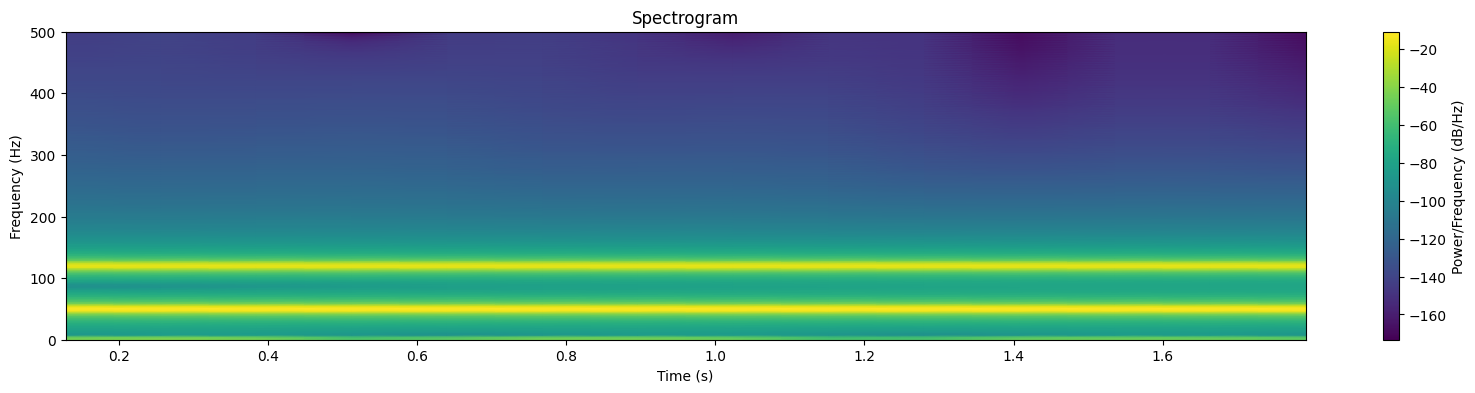

In [6]:
from scipy.signal import spectrogram

# Example signal
fs = 1000  # Sampling frequency in Hz
T = 2      # Duration in seconds
N = fs * T  # Total number of samples
t = np.linspace(0, T, N, endpoint=False)  # Time vector
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 120 * t)  # Signal

# Compute the spectrogram
frequencies, times, Sxx = spectrogram(x, fs, nperseg=256, noverlap=128, window='hann')

print('frequenceis shape : ', frequencies.shape)
print('times shape ', times.shape)
print('Sxx shape : ', Sxx.shape)

# Plot the spectrogram
plt.figure(figsize=(20, 4))
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')  # Convert to dB scale
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

shape of y : (4801936,)


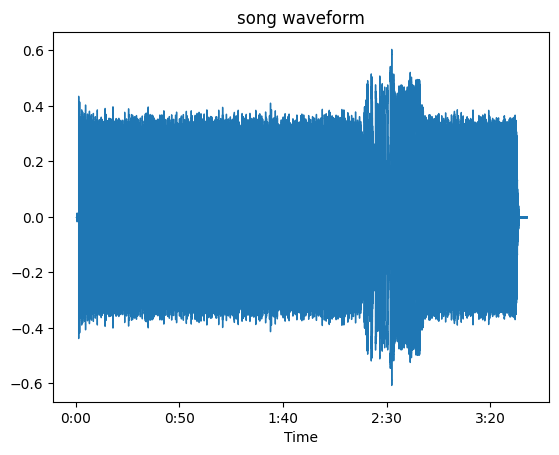

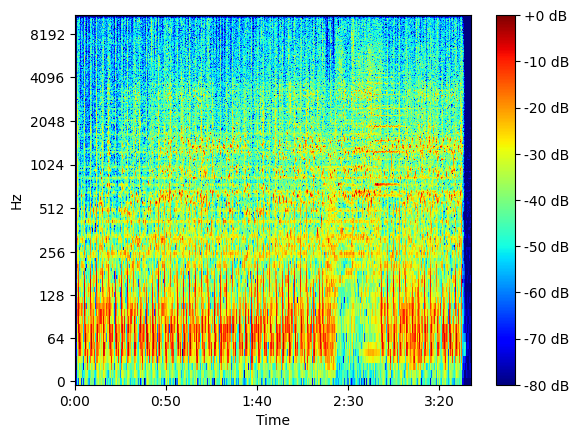

In [ ]:
song_name = 'bob-sinclar-world-hold-on-official-video (1).mp3'
audio_file = os.path.join('database', song_name)

y, sr = librosa.load(audio_file)

print('shape of y :', y.shape)
fig, ax = plt.subplots(nrows=1, sharex=True)
librosa.display.waveshow(y=y, sr=sr, ax=ax)
plt.title('song waveform')
plt.show()

n_fft = 2048 #  Number of samples in each FFT window. Higher values improve frequency resolution but reduce time resolution
hop_length = n_fft // 4  # 512, The number of samples between successive FFT frames. Smaller values increase overlap, providing smoother time representation.

stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)
spectrogram = np.abs(stft)
spectrogram_dB = librosa.amplitude_to_db(spectrogram, ref=np.max)
librosa.display.specshow(spectrogram_dB, sr=sr, cmap='jet', hop_length=hop_length, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [ ]:
# the point cloud selection 
